In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
hbar = 1.0545718e-34  # ℏ (Дж·с)
m_e = 9.10938356e-31  # масса электрона (кг)
eV = 1.602176634e-19  # коэффициент перевода эВ в Дж

a_default = 0.5e-9  # Ширина потенциальной ямы (м)
c_default = 2.0e-9   # Период решетки (м)


In [3]:
def get_V(x, a, c, U0):
    """
    Создание периодического потенциала Кронига-Пенни
    
    Формула потенциала:
        V(x) = 0,  если (x mod c) < a     (потенциальная яма)
        V(x) = U0, если (x mod c) >= a    (потенциальный барьер)
    
    Parameters:
        x : массив координат
        a : ширина ямы (м)
        c : период решетки (м)
        U0 : высота барьера (эВ)
    """
    V = np.zeros_like(x)
    x_mod = x % c  # Остаток от деления на период (для периодичности)
    mask_barrier = (x_mod > a)  # Маска для областей барьера
    V[mask_barrier] = U0  # Назначение высоты барьера
    return V

def calculate_RHS_user_formula(E, a, c, U0):
    """
    Вычисление правой части дисперсионного уравнения Кронига-Пенни
    
    Дисперсионное уравнение:
        cos(kc) = (P/(αa))·sin(αa) + cos(αa)
    
    Где:
        α = sqrt(2mE)/ħ - волновое число в яме
        P = (m·c·U0·b)/ħ² - безразмерный параметр барьера
        b = c - a - ширина барьера
        k - волновой вектор в решетке
    
    Разрешенные зоны: |RHS| <= 1
    """
    # Перевод энергии из эВ в Джоули
    E_J = E * eV  # Энергия в Джоулях
    U0_J = U0 * eV  # Высота барьера в Джоулях
    b_barrier = c - a  # Ширина барьера (м)
    
    # Вычисление волнового числа α в яме
    # α = √(2mE)/ħ
    valid_mask = E > 0  # Маска для положительных энергий
    alpha = np.zeros_like(E)  # Массив для волновых чисел
    alpha[valid_mask] = np.sqrt(2 * m_e * E_J[valid_mask]) / hbar
    alpha[alpha == 0] = 1e-10  # Защита от деления на ноль
    
    # Безразмерный параметр барьера P
    # P = (m·c·U0·b)/ħ² - характеризует "силу" барьера
    P = (m_e * c * U0_J * b_barrier) / (hbar**2)
    
    # Вычисление двух слагаемых правой части дисперсионного уравнения:
    # term1 = (P/(αa))·sin(αa) - вклад от барьера
    # term2 = cos(αa) - вклад от ямы
    term1 = (P / (alpha * a)) * np.sin(alpha * a)
    term2 = np.cos(alpha * a)
    
    # Правая часть дисперсионного уравнения: F(E) = term1 + term2
    rhs = term1 + term2
    return rhs

def analyze_bands(E, allowed, title_prefix=""):
    """
    Анализ и вывод информации о разрешенных и запрещенных зонах
    
    Parameters:
        E : массив энергий (эВ)
        allowed : булев массив разрешенных состояний (|F(E)| ≤ 1)
        title_prefix : префикс для заголовка
    """
    print(f"\n--- {title_prefix} ---")
    if len(E) == 0: return

    # Нахождение индексов, где меняется состояние (разрешенное/запрещенное)
    changes = np.where(np.diff(allowed.astype(int)))[0]
    is_allowed = allowed[0]  # Текущее состояние
    start_idx = 0  # Начальный индекс зоны
    
    for idx in changes:
        end_idx = idx
        width = E[end_idx] - E[start_idx]  # Ширина зоны (эВ)
        if width > 0.001:  # Игнорируем очень узкие зоны
            status = "Разрешенная" if is_allowed else "Запрещенная"
            print(f"{status}: {E[start_idx]:6.3f} ... {E[end_idx]:6.3f} эВ (Ширина: {width:6.3f} эВ)")
        is_allowed = not is_allowed  # Смена типа зоны
        start_idx = idx + 1
    
    # Обработка последней зоны
    width = E[-1] - E[start_idx]
    if width > 0.001:
        status = "Разрешенная" if is_allowed else "Запрещенная"
        print(f"{status}: {E[start_idx]:6.3f} ... {E[-1]:6.3f} эВ (Ширина: {width:6.3f} эВ)")

def run_simulation(a, c, U0, E_max):
    """
    Основная функция для запуска моделирования зонной структуры
    
    Parameters:
        a : ширина ямы (м)
        c : период решетки (м)
        U0 : высота барьера (эВ)
        E_max : максимальная энергия для расчета (эВ)
    """
    # Форматирование параметров для заголовков
    a_nm = a * 1e9  # Перевод в нанометры
    c_nm = c * 1e9  # Перевод в нанометры
    params_str = f"Параметры: ширина ямы a = {a_nm:.1f} нм, период решетки c = {c_nm:.1f} нм, высота барьера U₀ = {U0:.1f} эВ"
    
    # Дискретизация по энергии для расчета дисперсионного соотношения
    E = np.linspace(0.01, E_max, 10000) 
    
    # Расчет правой части дисперсионного уравнения F(E)
    rhs = calculate_RHS_user_formula(E, a, c, U0)
    
    # Определение разрешенных зон: |F(E)| ≤ 1
    allowed = np.abs(rhs) <= 1.0
    
    analyze_bands(E, allowed, params_str)
    
    # 1. Потенциальный профиль
    plt.figure(figsize=(9, 4.5))
    x_pot = np.linspace(-1.0*c, 3.0*c, 1000)  # Координаты для отображения 3 периодов
    V_vals = get_V(x_pot, a, c, U0)  # Значения потенциала
    plt.plot(x_pot*1e9, V_vals, 'k-', linewidth=2)
    plt.fill_between(x_pot*1e9, 0, V_vals, color='skyblue', alpha=0.4)
    plt.title(f"Потенциальный профиль модели\n{params_str}", pad=15, fontsize=12)
    plt.xlabel("Координата, x (нм)", fontsize=11)
    plt.ylabel("Энергия потенциала, V (эВ)", fontsize=11)
    if U0 > 50:  # Ограничение масштаба для больших U0
        plt.ylim(0, 50) 
        plt.text(0, 40, "Масштаб ограничен (U₀ → ∞)", color='red', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # 2. Дисперсионное уравнение
    plt.figure(figsize=(9, 4.5))
    plt.plot(E, rhs, label='F(E) = (P/αa)·sin(αa) + cos(αa)', color='darkblue')
    plt.axhline(1, c='r', ls='--', alpha=0.7, label='F(E) = ±1 (граница разрешенных зон)')
    plt.axhline(-1, c='r', ls='--', alpha=0.7)
    plt.fill_between(E, 1, -1, where=allowed, color='limegreen', alpha=0.3, label='Разрешенные зоны (|F(E)| ≤ 1)')
    plt.ylim(-2.5, 2.5)
    plt.xlim(0, E_max)
    plt.title(f"Графическое решение дисперсионного уравнения модели Кронига-Пенни\n" +
              f"cos(kc) = F(E), α = √(2mE)/ħ\n" + 
              f"P = m·c·U₀·(c-a)/ħ²\n" +
              f"{params_str}", pad=15, fontsize=11)
    plt.xlabel("Энергия электрона, E (эВ)", fontsize=11)
    plt.ylabel("Функция F(E) (безразмерная)", fontsize=11)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # 3. Зонная структура E(k)
    plt.figure(figsize=(9, 6))
    
    # Вычисление волнового вектора k из дисперсионного соотношения:
    # k = arccos(F(E))/c, где F(E) - правая часть уравнения
    k_vals = np.full_like(E, np.nan)  # Массив для k
    k_vals[allowed] = np.arccos(np.clip(rhs[allowed], -1, 1)) / c
    k_nm = k_vals * 1e-9  # Перевод в 1/нм для наглядности
    
    # Построение дисперсионной кривой E(k) для разрешенных зон
    plt.plot(k_nm, E, 'o', markersize=1.5, color='crimson', alpha=0.6, 
             label='Разрешенные состояния (энергия E при различных волновых числах k)')
    plt.plot(-k_nm, E, 'o', markersize=1.5, color='crimson', alpha=0.6)  # Симметрия
    
    # Заливка разрешенных зон
    for i in range(len(E)-1):
        if allowed[i] and allowed[i+1]:
            plt.axhspan(E[i], E[i+1], color='limegreen', alpha=0.1, linewidth=0)

    # Границы зоны Бриллюэна: k = ±π/c
    k_BZ = np.pi / c * 1e-9  # Граница зоны Бриллюэна в 1/нм
    plt.axvline(k_BZ, color='blue', linestyle=':', alpha=0.6, linewidth=1.2, 
                label=f'Граница зоны Бриллюэна: ±π/c = ±{k_BZ:.2f} нм⁻¹')
    plt.axvline(-k_BZ, color='blue', linestyle=':', alpha=0.6, linewidth=1.2)
    
    plt.title(f"Зонная структура одномерного кристалла\n" +
              f"Зависимость энергии E от волнового вектора k\n" +
              f"{params_str}", pad=15, fontsize=11)
    
    plt.xlabel("Волновой вектор, k (нм⁻¹)", fontsize=11)
    plt.ylabel("Энергия электрона, E (эВ)", fontsize=11)
    plt.xlim(-k_BZ * 1.5, k_BZ * 1.5)  # Ограничение по k
    
    plt.legend(loc='upper center', fontsize=9.5, bbox_to_anchor=(0.5, -0.12), ncol=1)
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    
    plt.show()


--- Параметры: ширина ямы a = 0.5 нм, период решетки c = 2.0 нм, высота барьера U₀ = 0.1 эВ ---
Запрещенная:  0.010 ...  0.700 эВ (Ширина:  0.690 эВ)
Разрешенная:  0.701 ...  1.503 эВ (Ширина:  0.802 эВ)
Запрещенная:  1.505 ...  3.175 эВ (Ширина:  1.670 эВ)
Разрешенная:  3.176 ...  6.016 эВ (Ширина:  2.839 эВ)
Запрещенная:  6.017 ...  8.065 эВ (Ширина:  2.048 эВ)
Разрешенная:  8.066 ... 13.537 эВ (Ширина:  5.470 эВ)
Запрещенная: 13.538 ... 15.000 эВ (Ширина:  1.462 эВ)


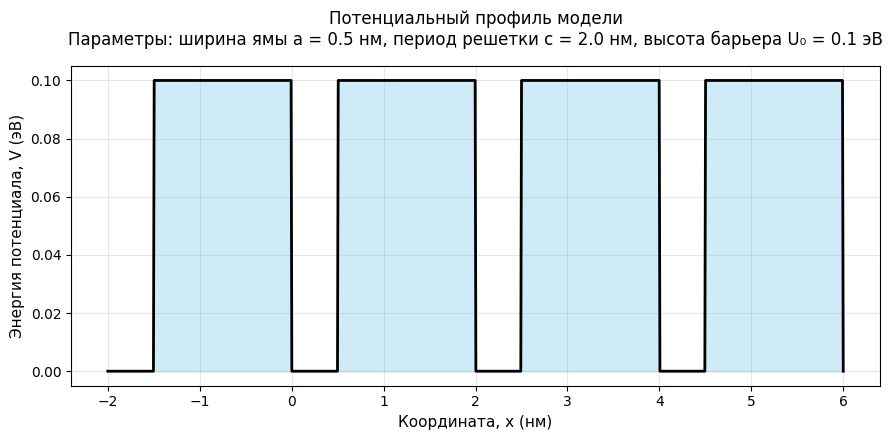

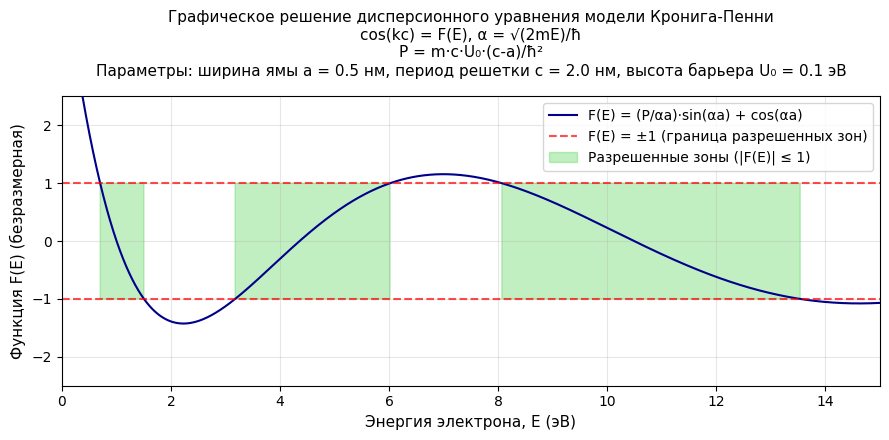

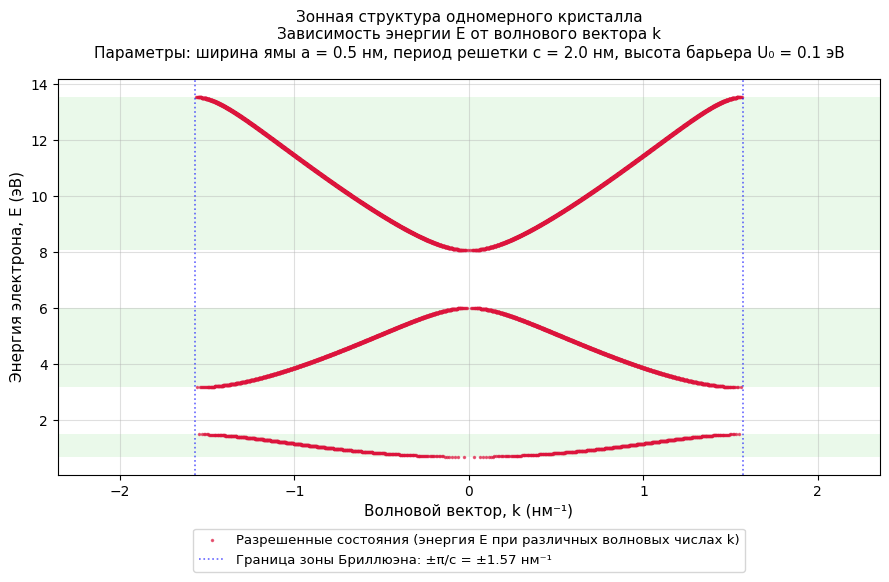


--- Параметры: ширина ямы a = 0.5 нм, период решетки c = 2.0 нм, высота барьера U₀ = 1.0 эВ ---
Запрещенная:  0.010 ...  1.362 эВ (Ширина:  1.352 эВ)
Разрешенная:  1.365 ...  1.502 эВ (Ширина:  0.137 эВ)
Запрещенная:  1.505 ...  5.451 эВ (Ширина:  3.946 эВ)
Разрешенная:  5.453 ...  6.016 эВ (Ширина:  0.562 эВ)
Запрещенная:  6.018 ... 12.279 эВ (Ширина:  6.261 эВ)
Разрешенная: 12.281 ... 13.536 эВ (Ширина:  1.255 эВ)
Запрещенная: 13.538 ... 21.856 эВ (Ширина:  8.318 эВ)
Разрешенная: 21.858 ... 24.065 эВ (Ширина:  2.207 эВ)
Запрещенная: 24.068 ... 25.000 эВ (Ширина:  0.932 эВ)


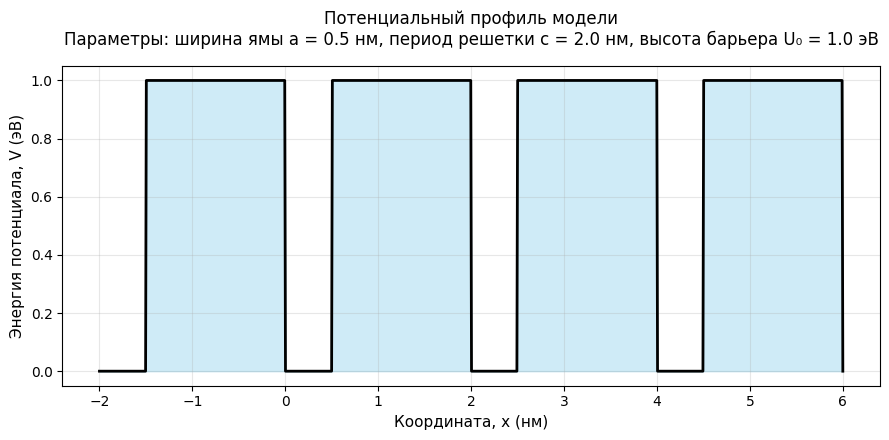

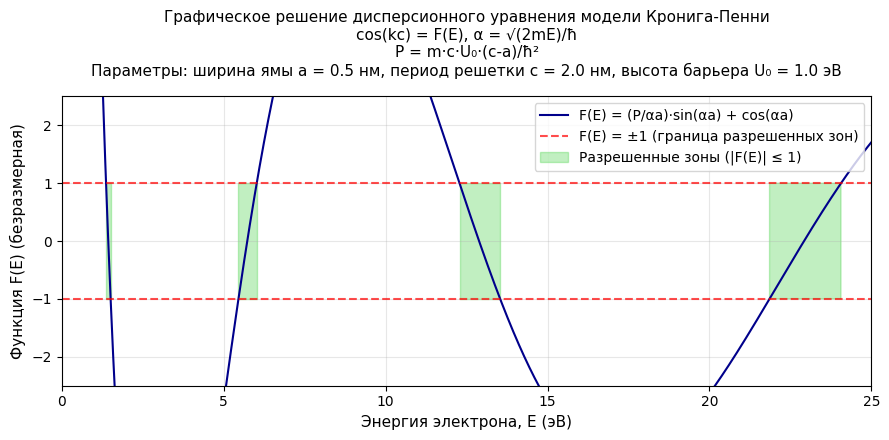

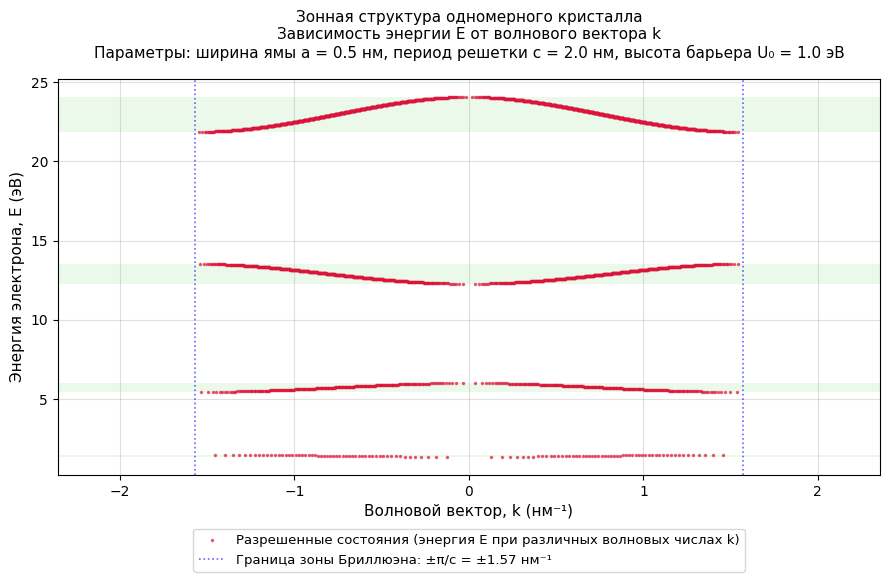


--- Параметры: ширина ямы a = 0.5 нм, период решетки c = 2.0 нм, высота барьера U₀ = 10.0 эВ ---
Запрещенная:  0.010 ...  1.487 эВ (Ширина:  1.477 эВ)
Разрешенная:  1.490 ...  1.502 эВ (Ширина:  0.012 эВ)
Запрещенная:  1.505 ...  5.956 эВ (Ширина:  4.451 эВ)
Разрешенная:  5.958 ...  6.016 эВ (Ширина:  0.057 эВ)
Запрещенная:  6.018 ... 13.398 эВ (Ширина:  7.380 эВ)
Разрешенная: 13.401 ... 13.536 эВ (Ширина:  0.135 эВ)
Запрещенная: 13.538 ... 23.823 эВ (Ширина: 10.284 эВ)
Разрешенная: 23.825 ... 24.065 эВ (Ширина:  0.240 эВ)
Запрещенная: 24.068 ... 25.000 эВ (Ширина:  0.932 эВ)


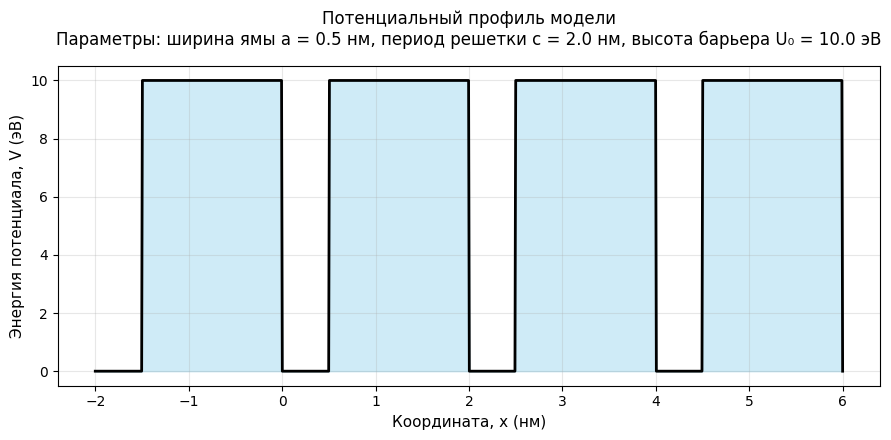

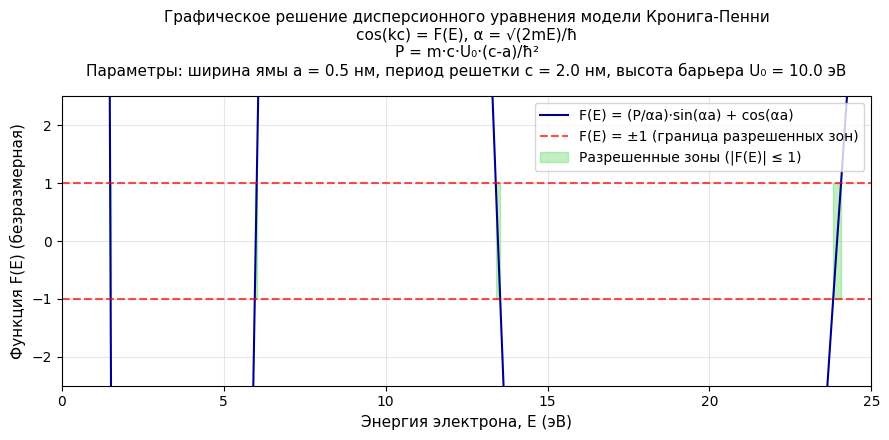

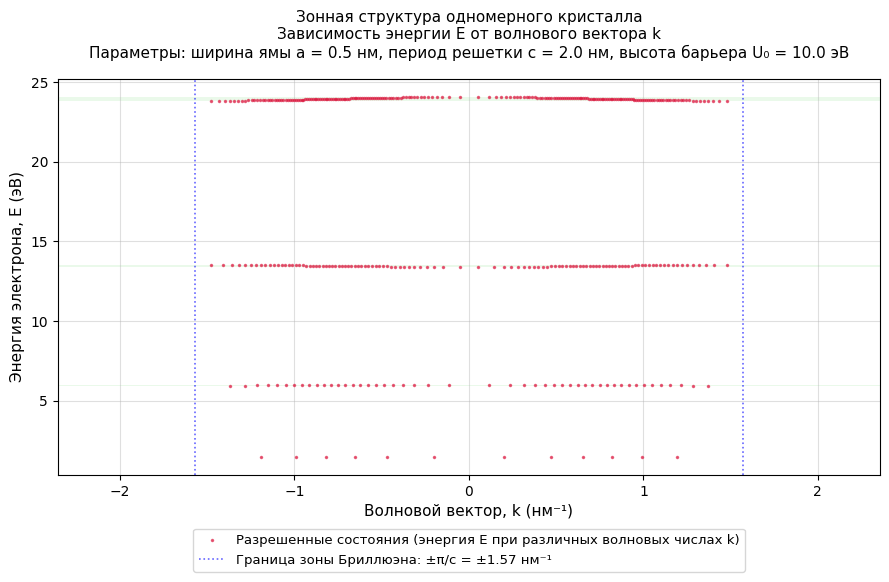


--- Параметры: ширина ямы a = 0.5 нм, период решетки c = 2.0 нм, высота барьера U₀ = 50.0 эВ ---
Запрещенная:  0.010 ...  5.999 эВ (Ширина:  5.989 эВ)
Разрешенная:  6.004 ...  6.014 эВ (Ширина:  0.010 эВ)
Запрещенная:  6.019 ... 13.509 эВ (Ширина:  7.489 эВ)
Разрешенная: 13.514 ... 13.534 эВ (Ширина:  0.020 эВ)
Запрещенная: 13.539 ... 24.013 эВ (Ширина: 10.474 эВ)
Разрешенная: 24.018 ... 24.063 эВ (Ширина:  0.045 эВ)
Запрещенная: 24.068 ... 37.526 эВ (Ширина: 13.459 эВ)
Разрешенная: 37.531 ... 37.601 эВ (Ширина:  0.070 эВ)
Запрещенная: 37.606 ... 50.000 эВ (Ширина: 12.394 эВ)


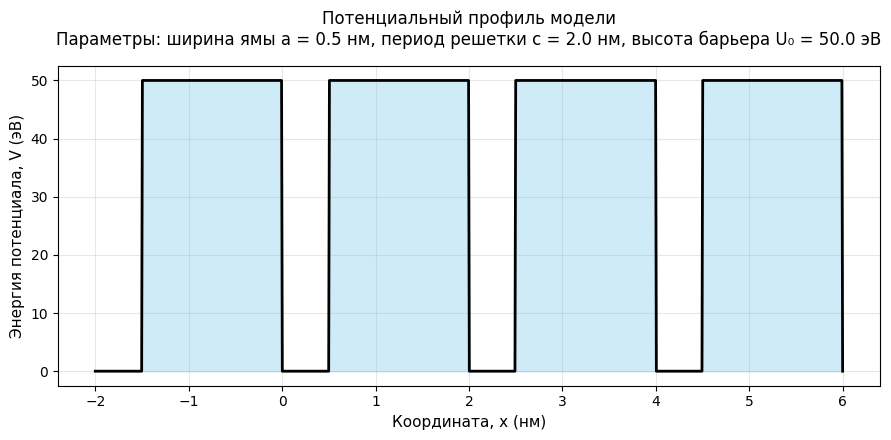

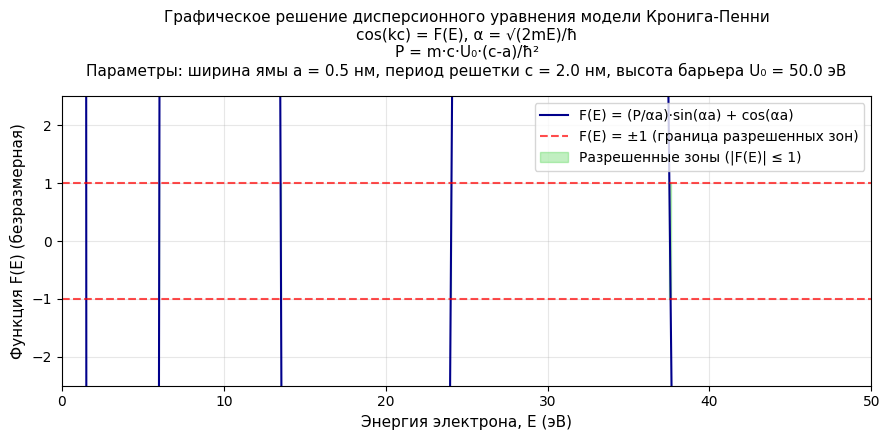

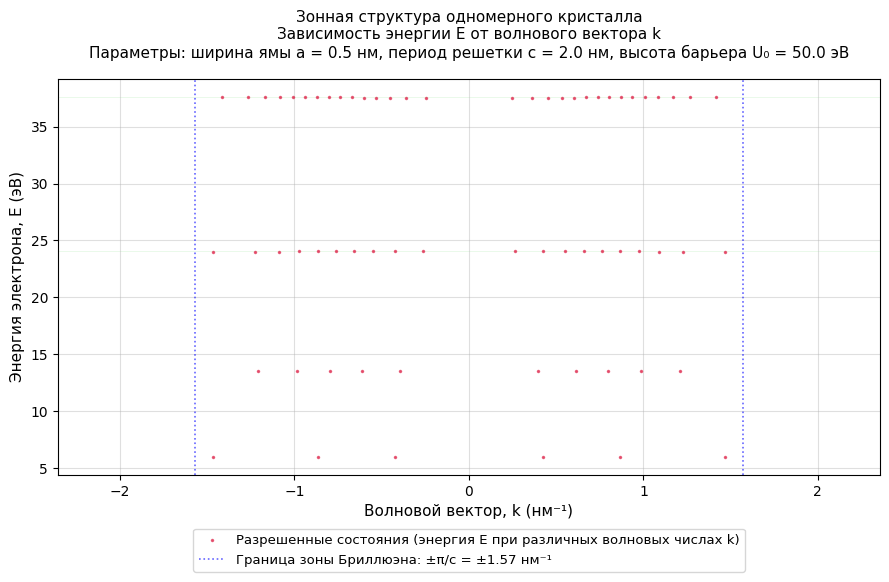


--- Параметры: ширина ямы a = 0.5 нм, период решетки c = 2.0 нм, высота барьера U₀ = 150.0 эВ ---
Запрещенная:  0.010 ... 13.520 эВ (Ширина: 13.510 эВ)
Запрещенная: 13.540 ... 24.040 эВ (Ширина: 10.500 эВ)
Разрешенная: 24.050 ... 24.060 эВ (Ширина:  0.010 эВ)
Запрещенная: 24.070 ... 37.570 эВ (Ширина: 13.500 эВ)
Разрешенная: 37.580 ... 37.600 эВ (Ширина:  0.020 эВ)
Запрещенная: 37.610 ... 54.110 эВ (Ширина: 16.500 эВ)
Разрешенная: 54.120 ... 54.140 эВ (Ширина:  0.020 эВ)
Запрещенная: 54.150 ... 73.650 эВ (Ширина: 19.500 эВ)
Разрешенная: 73.660 ... 73.700 эВ (Ширина:  0.040 эВ)
Запрещенная: 73.710 ... 96.190 эВ (Ширина: 22.480 эВ)
Разрешенная: 96.200 ... 96.260 эВ (Ширина:  0.060 эВ)
Запрещенная: 96.270 ... 100.000 эВ (Ширина:  3.730 эВ)


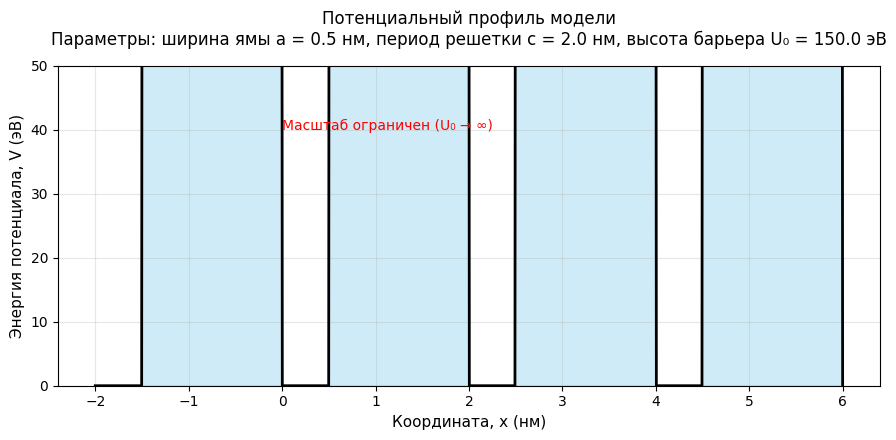

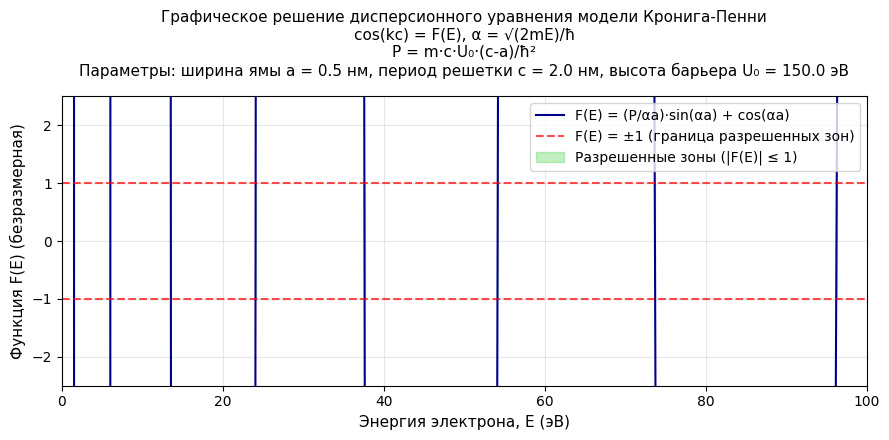

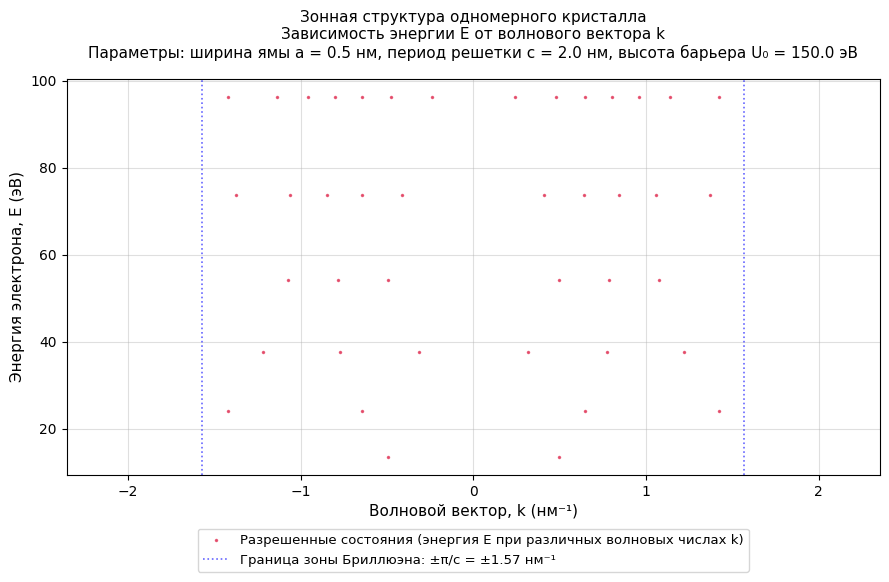

In [4]:
run_simulation(a_default, c_default, 0.1, 15)   # Очень слабый
run_simulation(a_default, c_default, 1.0, 25)   # Слабый
run_simulation(a_default, c_default, 10.0, 25)  # Исходный
run_simulation(a_default, c_default, 50.0, 50)  # Сильный
run_simulation(a_default, c_default, 150.0, 100) # Очень сильный
        